# IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pickle

In [2]:
df = pd.read_csv('ola.csv')

In [4]:
df.head()

,datetime,season,weather,temp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,3,2,7.653428,122.430885,18.783703,5,128,315.731778
1,2011-01-01 01:00:00,4,3,13.269244,101.703802,14.035245,36,184,340.457093
2,2011-01-01 02:00:00,1,3,30.886922,77.583743,45.365080,34,97,224.278595
3,2011-01-01 03:00:00,3,1,10.463377,114.925671,25.347168,6,47,132.169549
4,2011-01-01 04:00:00,3,4,30.214783,149.193592,20.288982,14,199,315.867137


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   weather     10886 non-null  int64  
 3   temp        9254 non-null   float64
 4   humidity    9254 non-null   float64
 5   windspeed   9254 non-null   float64
 6   casual      10886 non-null  int64  
 7   registered  10886 non-null  int64  
 8   count       10886 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 765.6+ KB


In [6]:
df.describe()

,season,weather,temp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,9254.000000,9254.000000,9254.000000,10886.000000,10886.000000,10886.000000
mean,2.493937,2.491916,23.240116,124.452421,34.549616,24.517545,99.551442,224.177267
std,1.120531,1.123139,20.311144,75.568291,28.417263,14.390014,57.541131,75.228602
min,1.000000,1.000000,-22.743852,32.713561,-1.407737,0.000000,0.000000,-12.769738
25%,1.000000,1.000000,12.470555,87.846187,17.963252,12.000000,50.000000,170.140221
50%,2.000000,2.000000,20.743790,112.180064,30.945593,25.000000,100.000000,224.257587
75%,3.000000,4.000000,29.394576,137.301002,44.029018,37.000000,149.000000,278.407366
max,4.000000,4.000000,211.102548,672.687236,244.921965,49.000000,199.000000,464.839068


In [7]:
df.isnull().sum()

datetime         0
season           0
weather          0
temp          1632
humidity      1632
windspeed     1632
casual           0
registered       0
count            0
dtype: int64

In [9]:
df = df.fillna(df.median(numeric_only=True))   # numeric columns
df = df.fillna(method='ffill')                 # non-numeric columns

C:\Users\DIKSH\AppData\Local\Temp\ipykernel_21348\1679136890.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')                 # non-numeric columns


In [10]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year

# Data Visualizations

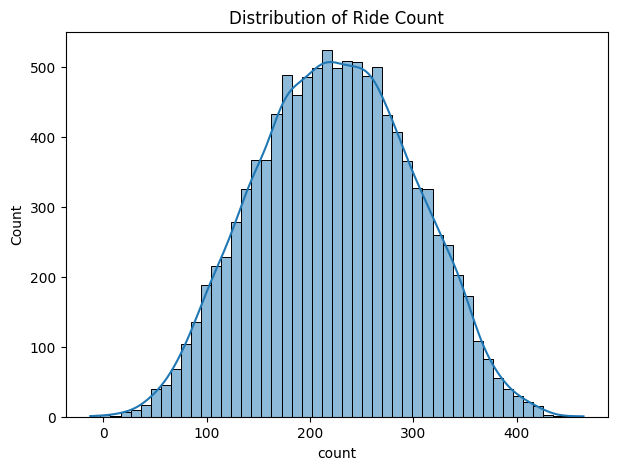

In [11]:
# Distribution of Target (Ride Count)
plt.figure(figsize=(7,5))
sns.histplot(df['count'], kde=True)
plt.title('Distribution of Ride Count')
plt.show()

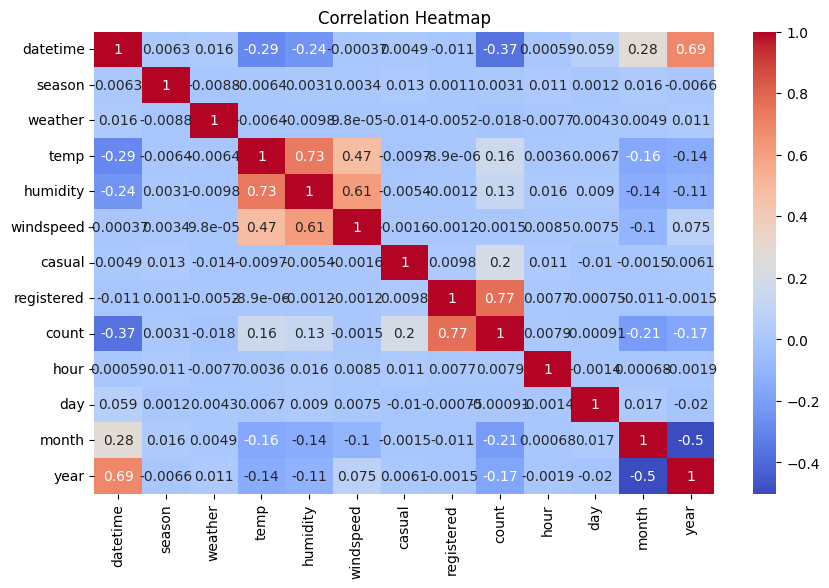

In [13]:
# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

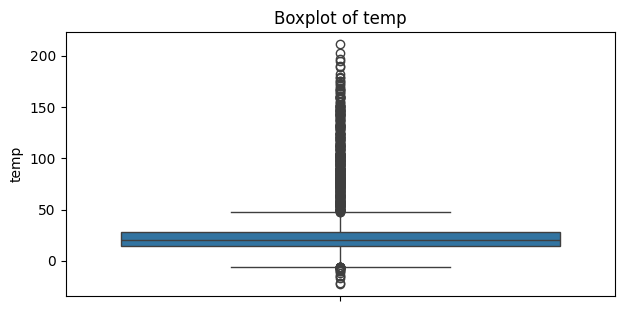

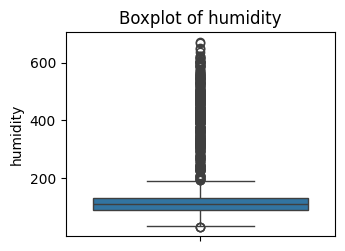

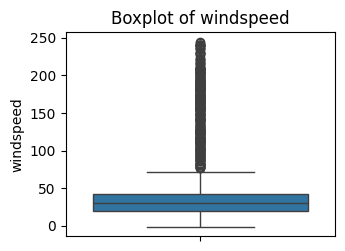

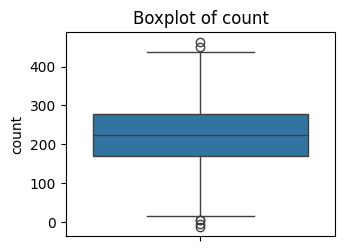

In [19]:
# Boxplots for Outlier Detection
cols = ['temp','humidity','windspeed','count']
plt.figure(figsize=(12,6))
for i, col in enumerate(cols):
    plt.subplot(2,2,i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()

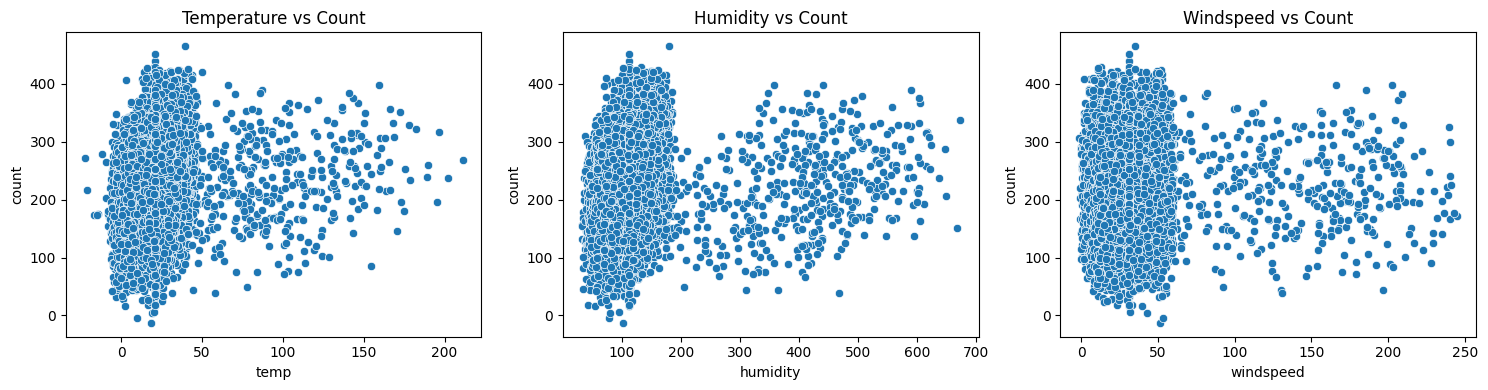

In [21]:
# Scatter Plots (Weather vs Ride Count)
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
sns.scatterplot(x=df['temp'], y=df['count'])
plt.title('Temperature vs Count')
plt.subplot(1,3,2)
sns.scatterplot(x=df['humidity'], y=df['count'])
plt.title('Humidity vs Count')
plt.subplot(1,3,3)
sns.scatterplot(x=df['windspeed'], y=df['count'])
plt.title('Windspeed vs Count')
plt.tight_layout()
plt.show()

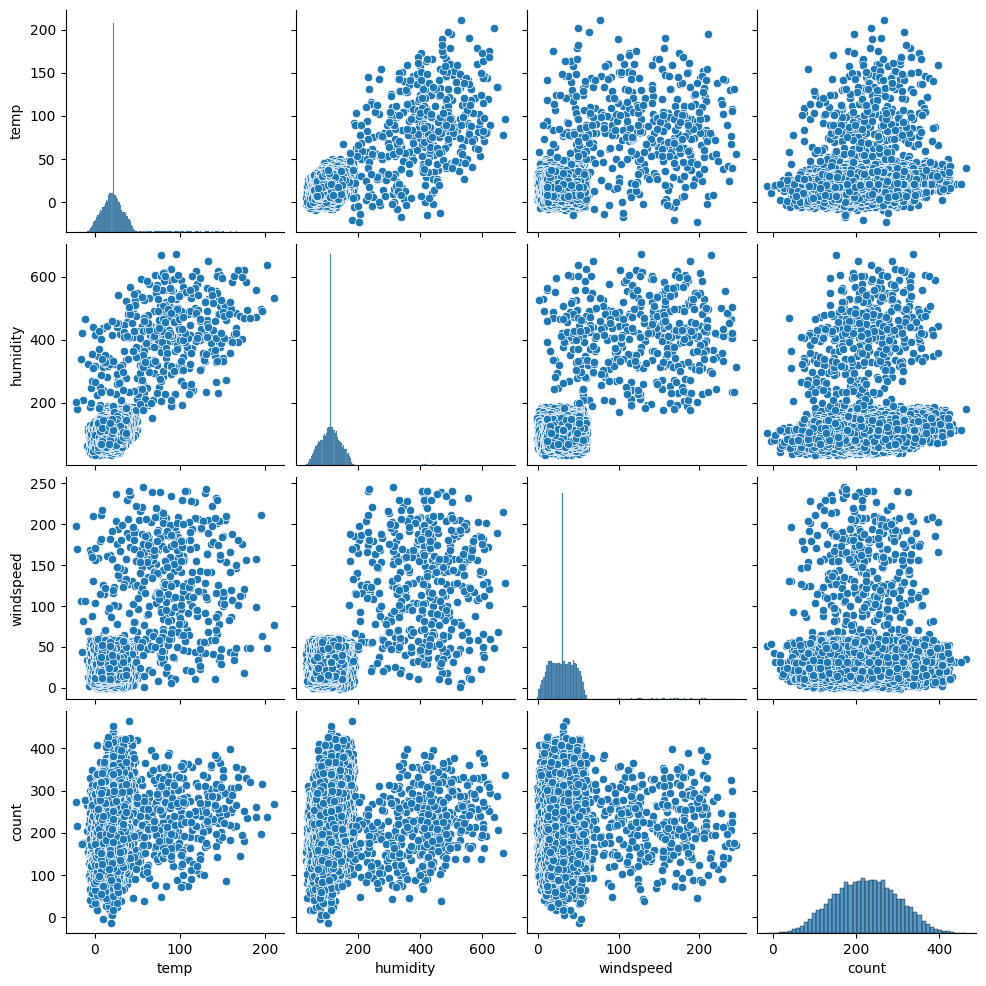

In [23]:
# Pairplot (Overall Data Relationship)
sns.pairplot(df[['temp','humidity','windspeed','count']])
plt.show()

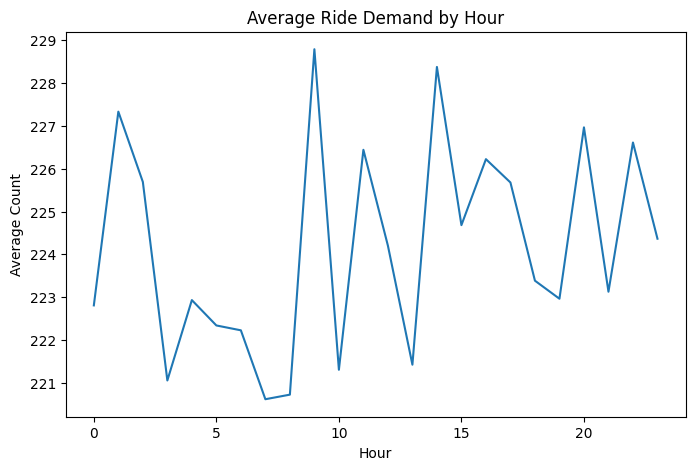

In [24]:
# Line Plot – Hourly Ride Demand
plt.figure(figsize=(8,5))
hourly = df.groupby('hour')['count'].mean()
plt.plot(hourly)
plt.title('Average Ride Demand by Hour')
plt.xlabel('Hour')
plt.ylabel('Average Count')
plt.show()

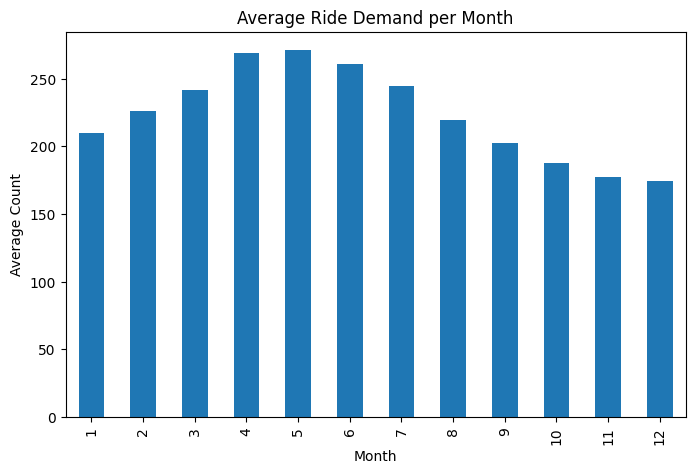

In [25]:
# Ride Count by Month
plt.figure(figsize=(8,5))
monthly = df.groupby('month')['count'].mean()
monthly.plot(kind='bar')
plt.title('Average Ride Demand per Month')
plt.xlabel('Month')
plt.ylabel('Average Count')
plt.show()

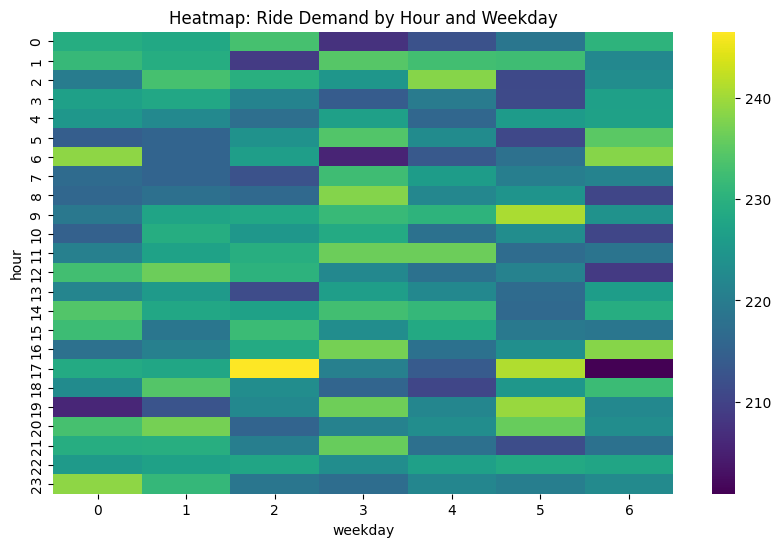

In [28]:
# Heatmap: Hour × Weekday Demand
df['weekday'] = df['datetime'].dt.dayofweek
pivot = df.pivot_table(values='count', index='hour', columns='weekday', aggfunc='mean')
plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap='viridis')
plt.title('Heatmap: Ride Demand by Hour and Weekday')
plt.show()

# Train‑Test Split

In [30]:
# Select Features & Target
X = df[['hour','day','month','year','temp','humidity','windspeed']]
y = df['count']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
# Model 1: Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)

In [34]:
# Model 2: Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [35]:
# Model 3: XGBoost
xgb = XGBRegressor(random_state=42, n_estimators=200, learning_rate=0.1)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

In [37]:
# Evaluation Function
def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("R2 Score:", r2)

In [40]:
# Evaluate All Models
print("Linear Regression:")
evaluate_model(y_test, lr_pred)

print("Random Forest:")
evaluate_model(y_test, rf_pred)

print("XGBoost:")
evaluate_model(y_test, xgb_pred)

Linear Regression:
MAE: 57.31299933579804
RMSE: 69.03274416032286
R2 Score: 0.14063355875469463
Random Forest:
MAE: 57.71396669835377
RMSE: 69.3095405955878
R2 Score: 0.13372824284818807
XGBoost:
MAE: 56.91947810533147
RMSE: 68.48688215773659
R2 Score: 0.15417034785317196


# Grid Search CV

In [41]:
# Hyperparameter Tuning – Random Forest
param_grid = {
'n_estimators': [100, 200],
'max_depth': [5, 10, None]
}


grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='r2')
grid.fit(X_train, y_train)


print("Best Parameters:", grid.best_params_)
best_rf = grid.best_estimator_
best_pred = best_rf.predict(X_test)

Best Parameters: {'max_depth': 5, 'n_estimators': 200}


In [42]:
# Evaluate Tuned Model
print("Tuned Random Forest:")
evaluate_model(y_test, best_pred)

Tuned Random Forest:
MAE: 55.1707876200441
RMSE: 66.10457030642773
R2 Score: 0.21199116248734706


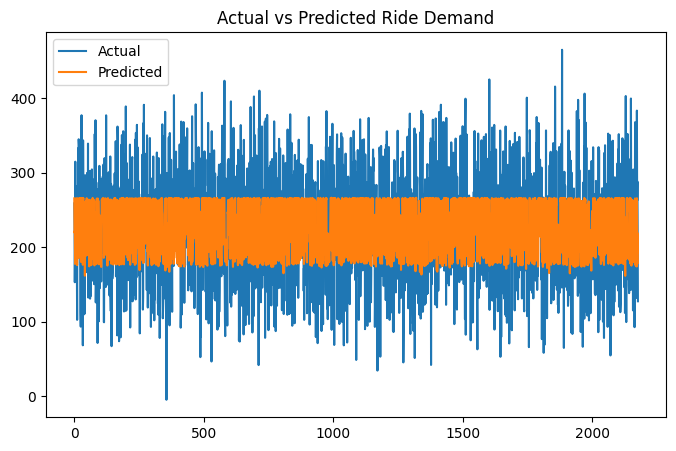

In [43]:
# Plot Actual vs Predicted
plt.figure(figsize=(8,5))
plt.plot(y_test.values, label='Actual')
plt.plot(best_pred, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Ride Demand')
plt.show()

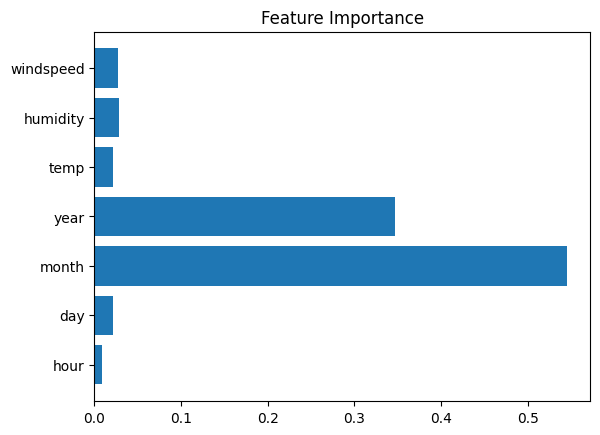

In [44]:
# Feature Importance (Random Forest)
importances = best_rf.feature_importances_
plt.barh(X.columns, importances)
plt.title('Feature Importance')
plt.show()